# Generate initial conditions file for high resolution experiment
We want to initialize the high res run with the solution of the 10km rum. Therefore we have to map 2D and 3D velocities, SSH, salinity and temperature fields on the new grid.
## Preparation of ini file
Load high and low resolution grid, low resolution history and low resolution ini file. 

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt

hr_grd_path = os.path.join(os.pardir,'data','preprocessing','interim','waom5_MinDepth20m_rx10.3_grd.nc')
hr_grd = xr.open_dataset(hr_grd_path)

lr_grd_path = os.path.join(os.pardir,'data','preprocessing','interim','waom10_MinDepth20m_rx10.3_grd.nc')
lr_grd = xr.open_dataset(lr_grd_path)

lr_his_path =  os.path.join(os.pardir,'data','raw','waom10_full_forcing','ocean_his_0005.nc')
lr_his = xr.open_dataset(lr_his_path).isel(ocean_time=-1)

lr_ini_path = os.path.join(os.pardir,'data','preprocessing','processed','waom10_ini.nc')
lr_ini = xr.open_dataset(lr_ini_path)

Prepare high resolution ini file by dropping all horizontal grid dependent variables from the low resolution ini file. 

In [2]:
hr_ini = lr_ini.drop(['u','v','ubar','vbar','salt','temp','zeta'])
hr_ini

<xarray.Dataset>
Dimensions:     (ocean_time: 1, one: 1, s_rho: 31)
Coordinates:
  * ocean_time  (ocean_time) timedelta64[ns] 00:00:00
Dimensions without coordinates: one, s_rho
Data variables:
    tstart      (one) float64 ...
    tend        (one) float64 ...
    theta_s     (one) float64 ...
    theta_b     (one) float64 ...
    Tcline      (one) float64 ...
    hc          (one) float64 ...
    Cs_r        (s_rho) float64 ...
    sc_r        (s_rho) float64 ...

## Interpolate low resolution variables on high resolution grid.
### 2D variables

Define function that takes low res data, and high res grid and returns high resolution data.

In [36]:
from scipy import interpolate

def low_to_high_2d(lr_da,lr_grd,hr_grd,gt):
    
    dummy = np.zeros(hr_grd['lon_'+gt].shape)
    x = hr_grd['xi_'+gt]
    y = hr_grd['eta_'+gt]
    hr_da = xr.DataArray(dummy,coords=[y,x],dims=['eta_'+gt,'xi_'+gt])

    # Fill the mask of low resolution data with nearest neibghours.
    data = lr_da.values
    
    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = interpolate.NearestNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)
    
    # Find index of bottom left corner of low res data on high res grid
    ind = (hr_grd['x_'+gt].values == lr_grd['x_'+gt][0,0].values) & (hr_grd['y_'+gt].values == lr_grd['y_'+gt][0,0].values)
    eta0, xi0 = np.array(np.nonzero(ind)).squeeze()
    
    # Fill in known values on high res grid
    hr_da[eta0::2,xi0::2] = filled
    
    # Now interpolate the intermediate grid points using x and y coordinates (in km from center point)
    
    # Points we know the data
    x = hr_grd['x_'+gt][0,xi0::2].values
    y = hr_grd['y_'+gt][eta0::2,0].values

    # Data at these points
    values = hr_da[eta0::2,xi0::2].to_masked_array()

    # Define the interpolation function (fast regular grid interpolation)
    interp_func = interpolate.RegularGridInterpolator((y,x),values,bounds_error=False,fill_value=None)

    # Define the target cells as meshgrid
    grid_x,grid_y = np.meshgrid(hr_grd['x_'+gt][0,:].values,hr_grd['y_'+gt][:,0].values)

    # Interpolate using linear interpolation
    interp = interp_func((grid_y[:,:],grid_x[:,:]))

    # Assign new data to data array
    hr_da[:,:] = interp

    # Fill with zeros where mask is present
    hr_da.values[hr_grd['mask_'+gt].values == 0] = 0.0
    
    return hr_da


In [39]:
u_da = low_to_high_2d(lr_his.ubar,lr_grd,hr_grd,'u')

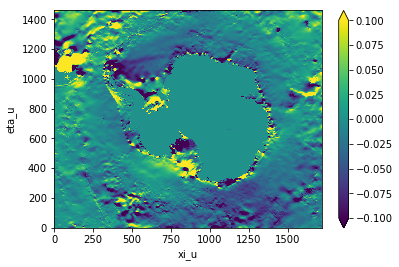

In [41]:
plt.close()
u_da.plot(vmin=-0.1,vmax=0.1)
plt.show()

In [28]:
grd_type = 'rho'
x_grd[grd_type]

<xarray.DataArray 'x_rho' (eta_rho: 1460, xi_rho: 1720)>
array([[-4295., -4290., -4285., ...,  4290.,  4295.,  4300.],
       [-4295., -4290., -4285., ...,  4290.,  4295.,  4300.],
       [-4295., -4290., -4285., ...,  4290.,  4295.,  4300.],
       ..., 
       [-4295., -4290., -4285., ...,  4290.,  4295.,  4300.],
       [-4295., -4290., -4285., ...,  4290.,  4295.,  4300.],
       [-4295., -4290., -4285., ...,  4290.,  4295.,  4300.]])
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  X-location of RHO-points
    units:      meter

In [59]:
dummy = np.zeros(hr_grd.lon_rho.shape)
x = hr_grd.xi_rho
y = hr_grd.eta_rho
zeta_hr = xr.DataArray(dummy,coords=[y,x],dims=['eta_rho','xi_rho'])

Fill the mask of low resolution data with nearest neibghours.

In [48]:


data = lr_his.zeta.values

valid_mask = ~np.isnan(data)
coords = np.array(np.nonzero(valid_mask)).T
values = data[valid_mask]

it = interpolate.NearestNDInterpolator(coords,values)

filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

In [98]:
ind = (hr_grd.x_rho.values == lr_grd.x_rho[0,0].values) & (hr_grd.y_rho.values == lr_grd.y_rho[0,0].values)
eta0,xi0 = np.array(np.nonzero(ind)).squeeze()
eta0

1

Fill every second grid point with low resolution data.
CAUTION: The bottom left corner of the high res grid is not equal the low res grid, but shifted by one grid cell.

In [6]:
print('Latitude cell [1,1] high res grid: ',hr_grd.lat_rho[1,1].values, ' cell [0,0] low res grid: ',lr_his.lat_rho[0,0].values)

Latitude cell [1,1] high res grid:  -41.01794065294183  cell [0,0] low res grid:  -41.01794065294183


Therefore fill in the high res grid starting from the second cell [1,1].

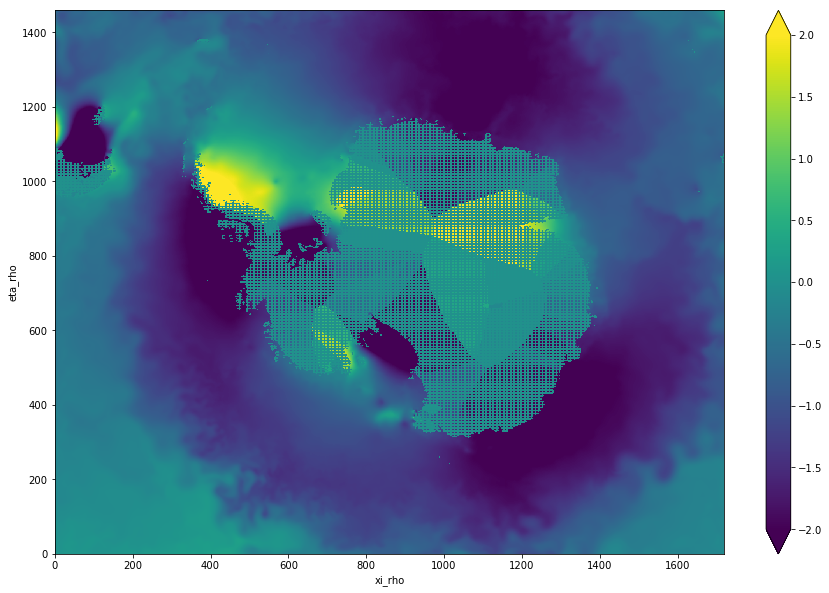

In [96]:
zeta_hr[bl[0]::2,bl[1]::2] = filled
plt.close()
zeta_hr.plot(vmin=-2,vmax=2,size=10)
plt.show()

Now interpolate the intermediate grid points simply using x_rho and y_rho coordinates (km from center). Make sure to interpolate from a masked array to not include land areas.

In [66]:
from scipy.interpolate import RegularGridInterpolator

# Points we know the data
x = hr_grd.x_rho[0,1::2].values
y = hr_grd.y_rho[1::2,0].values

# Data at these points
values = zeta_hr[1::2,1::2].to_masked_array()

# Define the interpolation function
interp_func = RegularGridInterpolator((y,x),values,bounds_error=False,fill_value=None)

# Define the target cells as meshgrid
grid_x,grid_y = np.meshgrid(hr_grd.x_rho[0,:].values,hr_grd.y_rho[:,0].values)

# Interpolate using linear interpolation
interp = interp_func((grid_y[:,:],grid_x[:,:]))

# Assign new data to data array
zeta_hr[:,:] = interp

# Apply the mask
zeta_hr.values[hr_grd.mask_rho.values == 0] = 0.0 

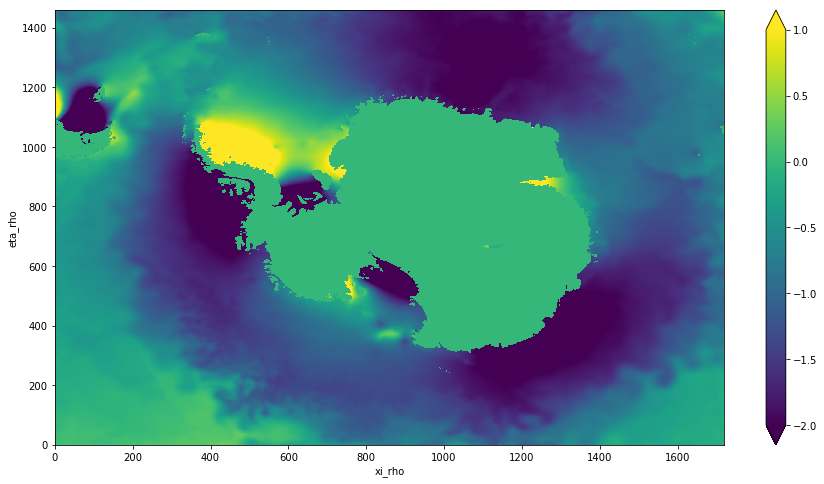

In [68]:
plt.close()
fig = plt.figure(figsize=(15,8))
zeta_hr.plot(vmin=-2,vmax=1)
plt.show()

We still have the issue that the high resolution mask includes values of the low resolution mask. To fix this, perform a nearest neighbour lookup at all low res locations (and the [:,0] and [0,:] lines) and apply high resolution mask afterwards.

In [21]:
B = zeta_hr.values

In [32]:
from scipy.interpolate import NearestNDInterpolator
valid = ~np.isnan(B)
coords = np.array(np.nonzero(valid)).T
values = B[valid]

it = NearestNDInterpolator(coords,values)

filled = it(list(np.ndindex(B.shape))).reshape(B.shape)

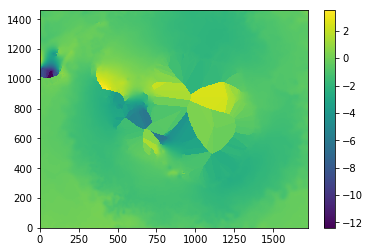

In [33]:
plt.close()
plt.pcolormesh(filled)
plt.colorbar()
plt.show()

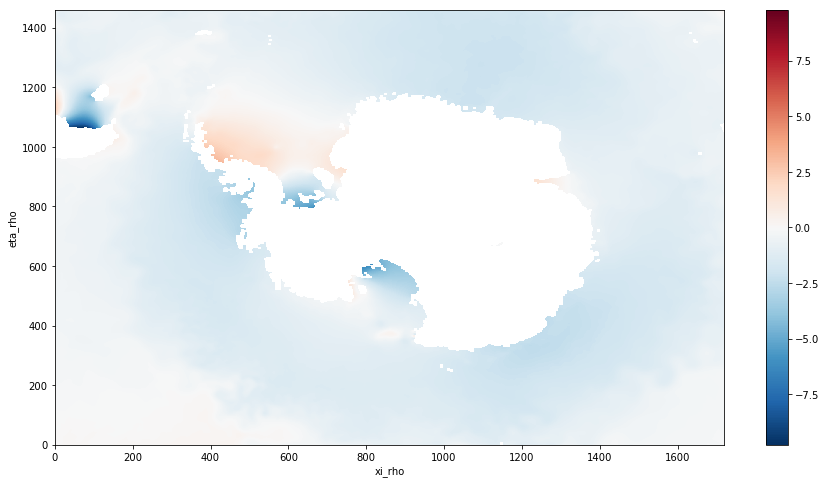

Assign to high resolution salt dataarray.

In [284]:
salt_da[0,1:,1:]=out
salt_da[0,0,1:]=out[0,:]
salt_da[0,1:,0]=out[:,0]
salt_da[0,0,0]=out[0,0]

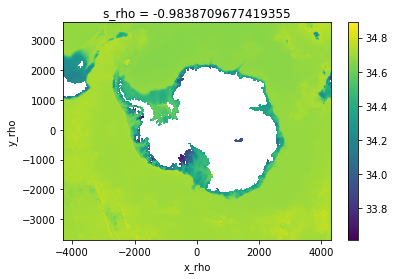

In [285]:
plt.close()
salt_da[0].plot()
plt.show()

## Prepare empty ini file
Since the grid is evenly spaced, we can simply interpolate on the grid coordinates (xi,eta).

In [21]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

hr_grid_path = os.path.join(os.pardir,'data','preprocessing','interim','waom5_MinDepth20_grd.nc')
hr_grid = xr.open_dataset(hr_grid_path)

lr_rst_path =  os.path.join(os.pardir,'data','raw','waom10_full_forcing','ocean_rst.nc')
lr_rst = xr.open_dataset(lr_rst_path).isel(ocean_time=0)

lr_ini_path = os.path.join(os.pardir,'data','raw','waom10_small_domain','Data','waom10','waom10_ini.nc')
lr_ini = xr.open_dataset(lr_ini_path)

hr_ini = lr_ini.drop(['u','v','ubar','vbar','salt','temp','zeta'])

In [33]:
data = np.empty(hr_grid.mask_u.shape)

lr_rst.ocean_time.expand_dims?
hr_grid.mask_u.shape

(1460, 1719)

In [36]:
ubar = xr.DataArray(np.empty(hr_grid.mask_u.shape),dims=['eta_u','xi_u'],coords=[hr_grid.eta_u,hr_grid.xi_u])
ubar.expand_dims('ocean_time',0)
ubar['ocean_time']=lr_rst.ocean_time

In [37]:
ubar

<xarray.DataArray (eta_u: 1460, xi_u: 1719)>
array([[  1.635084e-316,   6.924499e-310,   1.635084e-316, ...,   0.000000e+000,
          0.000000e+000,   0.000000e+000],
       [  0.000000e+000,   0.000000e+000,   0.000000e+000, ...,   0.000000e+000,
          0.000000e+000,   0.000000e+000],
       [  0.000000e+000,   0.000000e+000,   0.000000e+000, ...,   0.000000e+000,
          0.000000e+000,   0.000000e+000],
       ..., 
       [  0.000000e+000,   0.000000e+000,   0.000000e+000, ...,   0.000000e+000,
          0.000000e+000,   0.000000e+000],
       [  0.000000e+000,   0.000000e+000,   0.000000e+000, ...,   0.000000e+000,
          0.000000e+000,   0.000000e+000],
       [  0.000000e+000,   0.000000e+000,   0.000000e+000, ...,   0.000000e+000,
          0.000000e+000,   0.000000e+000]])
Coordinates:
  * eta_u       (eta_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    ocean_time  datetim